In [58]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from finance_byu.regtables import Regtable
import warnings
import matplotlib.pyplot as plt

In [ ]:
# Load data into pandas dataframe
df = pd.read_parquet('Data/BoQ_Data.parquet')
df.head()

In [ ]:
reduced_variables = pd.read_excel('Data/Reduced Variables.xlsx',sheet_name="Sheet2", header=None)[0].to_list()
all_variables = pd.read_excel('Data/Variables.xlsx',sheet_name="Sheet2", header=None)[0].to_list()
for item in ['PERMNO', 'DATE', 'RET', 'SICCD']:
    all_variables.remove(item)
reduced_variables

In [20]:
def Regression(vars_list, dataframe=df):

    dataframe = df[vars_list + ['RET']]
    dataframe = dataframe.dropna().reset_index(drop=True)
    y = dataframe['RET']
    del dataframe['RET']
    reg_list = []

    X = dataframe
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    reg_list.append(model)
    return reg_list

In [21]:
reduced_regs = Regression(reduced_variables)
full_regs = Regression(all_variables)

In [30]:
all_regs = reduced_regs + full_regs
tbl = Regtable(all_regs, stat='tstat', sig='coeff')
df_coeffs = tbl.render()
df_coeffs.columns = ["Selected Variables", "All Variables"]
df_coeffs.to_csv("Data/OLS Coefficients.csv")

In [49]:
fun_vars = ['Turnover', 'cum_return_60_1', 'Recession']

# The world economy has experienced four global recessions over the past seven decades: in 1975, 1982, 1991, and 2009.

df['Recession'] = pd.DatetimeIndex(df['DATE']).year.isin([1975, 1982, 1991, 2009]) * 1

model_list = Regression(fun_vars)

fun_tbl = Regtable(model_list, stat='tstat', sig='coeff')
fun_tbl.render()

,RET
const,0.011***
,(88.81)
Turnover,0.002***
,(34.24)
cum_return_60_1,-0.000***
,(-11.46)
Recession,0.027***
,(56.70)
obs,1988636
Rsq,0.00


/var/folders/vj/8t2xdhb577n2gr_0n_gppv480000gn/T/ipykernel_3451/3450286228.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.dropna(inplace=True)
/var/folders/vj/8t2xdhb577n2gr_0n_gppv480000gn/T/ipykernel_3451/3450286228.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['diff'] = test['mom'] - test['cum_return_12_2']


<Axes: xlabel='DATE'>

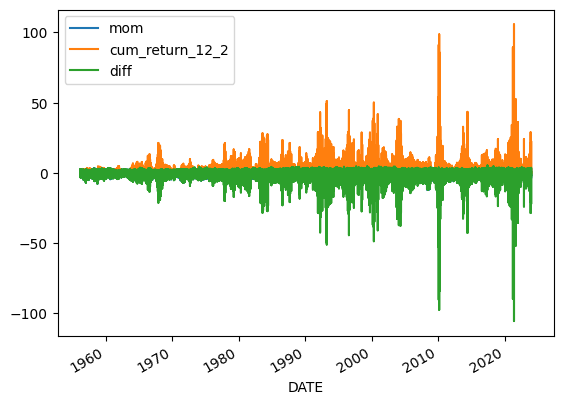

In [72]:
# # For calculating momentum portfolios - ignore for now
# warnings.simplefilter('ignore')
# variables_of_interest = ['PERMNO', 'DATE', 'RET', 'beta', 'idio_vol', 'BEME']
# subset = df[variables_of_interest]

# # Calculate monthly returns
# subset['MONTHYEAR'] = pd.DatetimeIndex(subset['DATE']).month.astype(str) + '-' + pd.DatetimeIndex(subset['DATE']).year.astype(str)
# subset['monthly_ret'] = subset.groupby('MONTHYEAR')['RET'].mean()

# monthly_data = subset.groupby(['MONTHYEAR', 'PERMNO'])[['RET', 'beta', 'idio_vol', 'BEME']].mean()
# monthly_data['DATE'] = subset.groupby(['MONTHYEAR', 'PERMNO'])['DATE'].min()

# monthly_data = monthly_data.reset_index()

# # Calculate momentum
df['logret'] = np.log(1 + df['RET'])
df['mom'] = df.groupby('PERMNO')['logret'].rolling(11,11).sum().reset_index(drop=True) # First we create the momentum
df['mom'] = df.groupby('PERMNO')['mom'].shift(2)

# monthly_data = monthly_data.dropna().reset_index(drop=True)
# monthly_data
test = df[['DATE', 'mom', 'cum_return_12_2']]
test.dropna(inplace=True)
#test = test[:400]
test['diff'] = test['mom'] - test['cum_return_12_2']
fig, ax = plt.subplots(1,1)
test.plot(y='mom', x='DATE', ax=ax)
test.plot(y='cum_return_12_2', x='DATE', ax=ax)
test.plot(y='diff', x='DATE', ax=ax)

In [ ]:
from itertools import combinations

def RobustnessCheck(dataframe: pd.DataFrame):

    reg_list = []
    vars_list = ['beta', 'idio_vol', 'BEME'] # If the data is monthly, we can use 'mom'

    dataframe = dataframe[vars_list + ['RET']].dropna().reset_index(drop=True)

    # Robustness check. The coefficients are pretty steady
    for i in range(1, len(vars_list)+1):
        for combo in combinations(vars_list, i):
            X = dataframe[list(combo)]
            X = sm.add_constant(X)
            y = dataframe['RET']
            model = sm.OLS(y, X).fit()
            reg_list.append(model)
    tbl = Regtable(reg_list,stat='tstat',sig='coeff')
    return tbl

tbl = RobustnessCheck(df)

tbl.render()

In [ ]:
tbl2 = RobustnessCheck(monthly_data)
tbl2.render()

In [ ]:
# Potential Sharpe Ratio function. Haven't debugged
def SharpeRatio(returns: pd.Series):
    # Note: This isn't exactly the Sharpe Ratio because we don't have the risk-free rate
    return np.mean(returns) / np.std(returns)

SharpeRatio(y)